In [83]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline

# Data Import & Prep

In [54]:
# read CSV's to dataframes
df_base = pd.read_csv("/Users/jeremyvanvalkenburg/Repositories/datasets/export_base.csv")
df_p2p = pd.read_csv("/Users/jeremyvanvalkenburg/Repositories/datasets/export_p2p.csv")

# filter out entries w/out any visitors
df_base = df_base[(df_base.visits!=0)&(df_base.visits!=0)]
df_p2p = df_p2p[df_p2p.base.isin(df_base.id.values.tolist())]

# merge the dataframes and generate donation conversion column
df = pd.merge(df_base, df_p2p, left_on='id', right_on='base')
df['donation_conversion'] = df['don_count'] / df['visits'] + df['mobile_visits']

# Correlations & value counts

In [56]:
df[['fields', 'amt_count', 'don_count']].corr()

,fields,amt_count,don_count
fields,1.000000,0.072683,-0.026774
amt_count,0.072683,1.000000,-0.029991
don_count,-0.026774,-0.029991,1.000000


# Donation Count Modeling

In [3]:
ftrs = ['class_count', 'cat_count', 'promo_count', 'rest_count', 'amt_count', 'ded_count', 
'fields', 'opt_fields', 'req_fields', 'allows_reg_ind', 'allows_teams', 'allows_reg_team_create', 
'allows_reg_team_join', 'allows_opt_reg_donation', 'allows_pfp_off_don', 'allows_tfp_off_don']

X_train, X_test, y_train, y_test = train_test_split(df[ftrs], df['don_count'], test_size=0.25)

# Linear Model

In [8]:
# linear model
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Prediction error: {}".format((y_pred-y_test).mean()))
print("R^2: {}".format(lr.score(X_test, y_test)))

Prediction error: 0.0170079877628
R^2: 0.0457520911154


### Feature Engineering

In [27]:
df['class_count^2'] = df['class_count']**2
df['class_count^3'] = df['class_count']**3
df['cat_count^2'] = df['cat_count']**2
df['cat_count^3'] = df['cat_count']**3

ftrs_eng = ['class_count', 'class_count^2', 'class_count^3', 'cat_count', 'cat_count^2', 'cat_count^3', 'promo_count', 'rest_count', 'amt_count', 'ded_count', 
'fields', 'opt_fields', 'req_fields', 'req_fields^2', 'req_fields^3', 'allows_reg_ind', 'allows_teams', 'allows_reg_team_create', 
'allows_reg_team_join', 'allows_opt_reg_donation', 'allows_pfp_off_don', 'allows_tfp_off_don']

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(df[ftrs_eng], df['don_count'], test_size=0.25)

In [28]:
# linear model
lr = LinearRegression(normalize=True)
lr.fit(X_train_eng, y_train_eng)
y_pred = lr.predict(X_test_eng)
print("Prediction error: {}".format((y_pred-y_test_eng).mean()))
print("R^2: {}".format(lr.score(X_test_eng, y_test_eng)))

Prediction error: 0.00529558632954
R^2: 0.107055642906


Original donation count for sample: 1


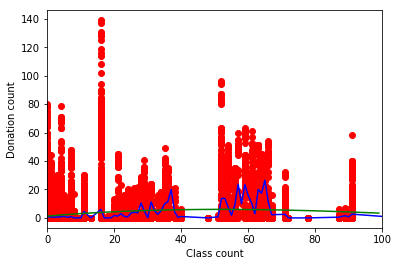

In [29]:
import matplotlib.pyplot as plt
# scatter for all data
df_sample = df[ftrs_eng+['don_count']]
# group by class count to see mean don_count
grpd = df[['don_count','class_count']].groupby('class_count').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs_eng+['don_count']].sample(1)
print("Original donation count for sample: {}".format(pred_sample['don_count'].iloc[0]))
for n in range(100):
    pred_sample['class_count'] = n
    pred_sample['class_count^2'] = n**2
    pred_sample['class_count^3'] = n**3
    y_preds.append(lr.predict(pred_sample.drop('don_count', axis=1))[0])

plt.scatter(df_sample['class_count'], df_sample['don_count'], color='r')
plt.plot(grpd.index, grpd['don_count'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,100)
plt.xlabel("Class count")
plt.ylabel("Donation count")
plt.show()

Original donation count for sample: 2


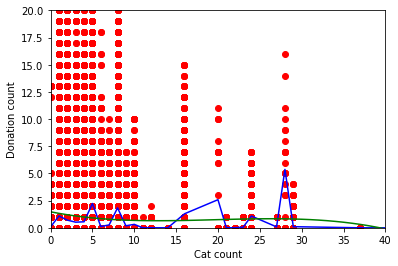

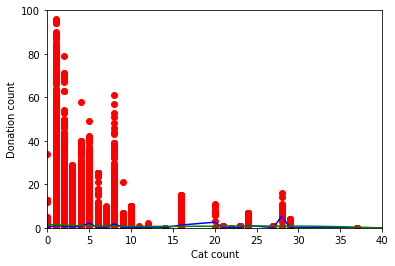

In [32]:
import matplotlib.pyplot as plt
# scatter for all data
df_sample = df[ftrs_eng+['don_count']]
# group by class count to see mean don_count
grpd = df[['don_count','cat_count']].groupby('cat_count').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs_eng+['don_count']].sample(1)
print("Original donation count for sample: {}".format(pred_sample['don_count'].iloc[0]))
for n in range(100):
    pred_sample['cat_count'] = n
    pred_sample['cat_count^2'] = n**2
    pred_sample['cat_count^3'] = n**3
    y_preds.append(lr.predict(pred_sample.drop('don_count', axis=1))[0])

plt.scatter(df_sample['cat_count'], df_sample['don_count'], color='r')
plt.plot(grpd.index, grpd['don_count'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0, 40)
plt.ylim(0, 20)
plt.xlabel("Cat count")
plt.ylabel("Donation count")
plt.show()

plt.scatter(df_sample['cat_count'], df_sample['don_count'], color='r')
plt.plot(grpd.index, grpd['don_count'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0, 40)
plt.ylim(0, 100)
plt.xlabel("Cat count")
plt.ylabel("Donation count")
plt.show()

## GBM

In [4]:
for n in [50, 100, 250, 500, 750, 1000]:
    gbr = GradientBoostingRegressor(n_estimators=n)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    print("GBR with {} estimators:".format(n))
    print("\tPrediction error: {}".format((y_pred-y_test).mean()))
    print("\tR^2: {}".format(gbr.score(X_test, y_test)))

GBR with 50 estimators:
	Prediction error: 0.0114393929503
	R^2: 0.312301736348
GBR with 100 estimators:
	Prediction error: 0.0116105192285
	R^2: 0.325778140344
GBR with 250 estimators:
	Prediction error: 0.0127397528886
	R^2: 0.338851118005
GBR with 500 estimators:
	Prediction error: 0.0143328933559
	R^2: 0.348484691494
GBR with 750 estimators:
	Prediction error: 0.0150067143875
	R^2: 0.353419775151
GBR with 1000 estimators:
	Prediction error: 0.0154150155308
	R^2: 0.355691376849


## Random Forest

In [95]:
ftrs = ['class_count', 'cat_count', 'promo_count', 'rest_count', 'amt_count', 'ded_count', 
'fields', 'opt_fields', 'req_fields', 'allows_reg_ind', 'allows_teams', 'allows_reg_team_create', 
'allows_reg_team_join', 'allows_opt_reg_donation', 'allows_pfp_off_don', 'allows_tfp_off_don']

X_train, X_test, y_train, y_test = train_test_split(df[ftrs], df['don_count'], test_size=0.25)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("R2: {}".format(rf.score(X_test, y_test)))
print("Feature importances:")
for i in range(len(X_train.columns)):
    print("\t{}: {}".format(X_train.columns[i], rf.feature_importances_[i]))

R2: 0.384459645983
Feature importances:
	class_count: 0.233582234864
	cat_count: 0.0692715211787
	promo_count: 0.0649135719319
	rest_count: 0.000106222412148
	amt_count: 0.0405918616351
	ded_count: 0.00956712644042
	fields: 0.0197804627072
	opt_fields: 0.0179203742434
	req_fields: 0.0128237793338
	allows_reg_ind: 0.285819667655
	allows_teams: 0.00981816133703
	allows_reg_team_create: 0.116032674046
	allows_reg_team_join: 0.000835137931369
	allows_opt_reg_donation: 0.117397118851
	allows_pfp_off_don: 0.000533627644779
	allows_tfp_off_don: 0.00100645778728


In [5]:
for n in [50, 100, 250, 500, 750, 1000]:
    rfr = RandomForestRegressor(n_estimators=n)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    print("Random Forest with {} estimators".format(n))
    print("\tPrediction error: {}".format((y_pred-y_test).mean()))
    print("\tR^2: {}".format(rfr.score(X_test, y_test)))

Random Forest with 50 estimators
	Prediction error: 0.013961775243
	R^2: 0.370793261863
Random Forest with 100 estimators
	Prediction error: 0.0151166809828
	R^2: 0.370011592688
Random Forest with 250 estimators
	Prediction error: 0.0148598906269
	R^2: 0.369939392117
Random Forest with 500 estimators
	Prediction error: 0.0147500895206
	R^2: 0.370060068553
Random Forest with 750 estimators
	Prediction error: 0.014537420257
	R^2: 0.370399247127
Random Forest with 1000 estimators
	Prediction error: 0.014597672982
	R^2: 0.370394961907


# NN

In [5]:
architectures = [(25,), (50,), (100,), (25,25,), (50,50,), (100,100,), (25,25,25,), (50,50,50,), (100,100,100,), (150,150,150,), (25,25,25,25,), (50,50,50,50,), (100,100,100,100,), (150,150,150,150,)]

for a in architectures:
    nn = MLPRegressor(hidden_layer_sizes=a)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    print("NN with {} architecture".format(a))
    print("\tPrediction error: {}".format((y_pred-y_test).mean()))
    print("\tR^2: {}".format(nn.score(X_test, y_test)))

NN with (25,) architecture
	Prediction error: 0.138729560875
	R^2: 0.341669786145
NN with (50,) architecture
	Prediction error: -0.0396742021609
	R^2: 0.339923966645
NN with (100,) architecture
	Prediction error: 0.0863893915074
	R^2: 0.352959237786
NN with (25, 25) architecture
	Prediction error: 0.0997050298224
	R^2: 0.360014003953
NN with (50, 50) architecture
	Prediction error: 0.0366697212666
	R^2: 0.368904650356
NN with (100, 100) architecture
	Prediction error: 0.0584093097099
	R^2: 0.369365272514
NN with (25, 25, 25) architecture
	Prediction error: -0.111767559972
	R^2: 0.366727811354
NN with (50, 50, 50) architecture
	Prediction error: 0.00614001712033
	R^2: 0.370884280495
NN with (100, 100, 100) architecture
	Prediction error: -0.0496286284365
	R^2: 0.375545350637
NN with (150, 150, 150) architecture
	Prediction error: -0.0232621587361
	R^2: 0.376865189478
NN with (25, 25, 25, 25) architecture
	Prediction error: -0.0338418869847
	R^2: 0.366746385079
NN with (50, 50, 50, 50) a

# Visualizing Random Forest Model

## Rebuild model

In [4]:
n = 50
rfr = RandomForestRegressor(n_estimators=n)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print("Random Forest with {} estimators".format(n))
print("\tPrediction error: {}".format((y_pred-y_test).mean()))
print("\tR^2: {}".format(rfr.score(X_test, y_test)))

Random Forest with 50 estimators
	Prediction error: -0.0185405124294
	R^2: 0.399263520826


## Visualization

In [5]:
import matplotlib.pyplot as plt

In [8]:
X_test.columns

Index([u'class_count', u'cat_count', u'promo_count', u'rest_count',
       u'amt_count', u'ded_count', u'fields', u'opt_fields', u'req_fields',
       u'allows_reg_ind', u'allows_teams', u'allows_reg_team_create',
       u'allows_reg_team_join', u'allows_opt_reg_donation',
       u'allows_pfp_off_don', u'allows_tfp_off_don'],
      dtype='object')

Original donation count for sample: 2


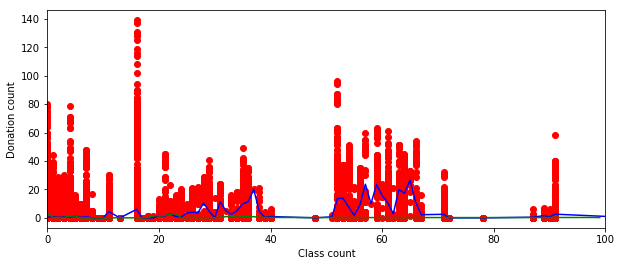

In [33]:
# scatter for all data
df_sample = df[ftrs+['don_count']]
# group by class count to see mean don_count
grpd = df[['don_count','class_count']].groupby('class_count').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs+['don_count']].sample(1)
print("Original donation count for sample: {}".format(pred_sample['don_count'].iloc[0]))
for n in range(100):
    pred_sample['class_count'] = n
    y_preds.append(rfr.predict(pred_sample.drop('don_count', axis=1))[0])

plt.scatter(df_sample['class_count'], df_sample['don_count'], color='r')
plt.plot(grpd.index, grpd['don_count'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,100)
plt.xlabel("Class count")
plt.ylabel("Donation count")
plt.show()

Original donation count for sample: 2


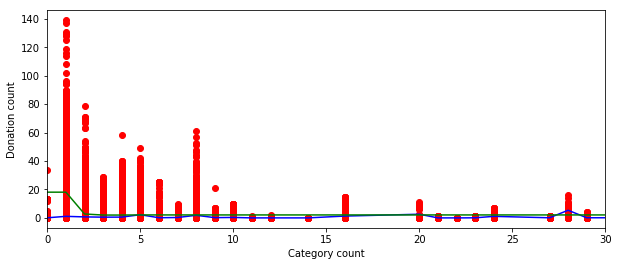

In [36]:
# scatter for all data
df_sample = df[ftrs+['don_count']]
# group by class count to see mean don_count
grpd = df[['don_count','cat_count']].groupby('cat_count').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs+['don_count']].sample(1)
print("Original donation count for sample: {}".format(pred_sample['don_count'].iloc[0]))
for n in range(100):
    pred_sample['cat_count'] = n
    y_preds.append(rfr.predict(pred_sample.drop('don_count', axis=1))[0])

plt.scatter(df_sample['cat_count'], df_sample['don_count'], color='r')
plt.plot(grpd.index, grpd['don_count'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,30)
plt.xlabel("Category count")
plt.ylabel("Donation count")
plt.show()

Original donation count for sample: 2


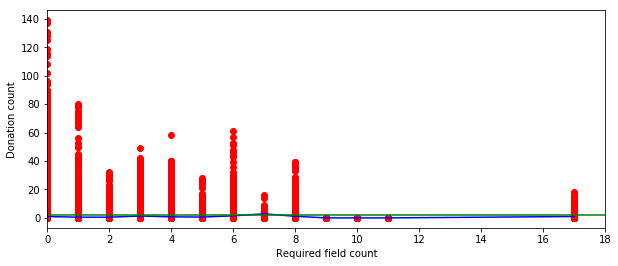

In [39]:
# scatter for all data
df_sample = df[ftrs+['don_count']]
# group by class count to see mean don_count
grpd = df[['don_count','req_fields']].groupby('req_fields').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs+['don_count']].sample(1)
print("Original donation count for sample: {}".format(pred_sample['don_count'].iloc[0]))
for n in range(100):
    pred_sample['req_fields'] = n
    y_preds.append(rfr.predict(pred_sample.drop('don_count', axis=1))[0])

plt.scatter(df_sample['req_fields'], df_sample['don_count'], color='r')
plt.plot(grpd.index, grpd['don_count'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,18)
plt.xlabel("Required field count")
plt.ylabel("Donation count")
plt.show()

Original donation count for sample: 11


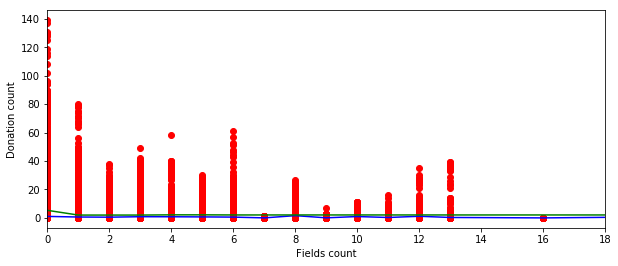

In [40]:
# scatter for all data
df_sample = df[ftrs+['don_count']]
# group by class count to see mean don_count
grpd = df[['don_count','fields']].groupby('fields').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs+['don_count']].sample(1)
print("Original donation count for sample: {}".format(pred_sample['don_count'].iloc[0]))
for n in range(100):
    pred_sample['fields'] = n
    y_preds.append(rfr.predict(pred_sample.drop('don_count', axis=1))[0])

plt.scatter(df_sample['fields'], df_sample['don_count'], color='r')
plt.plot(grpd.index, grpd['don_count'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,18)
plt.xlabel("Fields count")
plt.ylabel("Donation count")
plt.show()

Original donation count for sample: 3


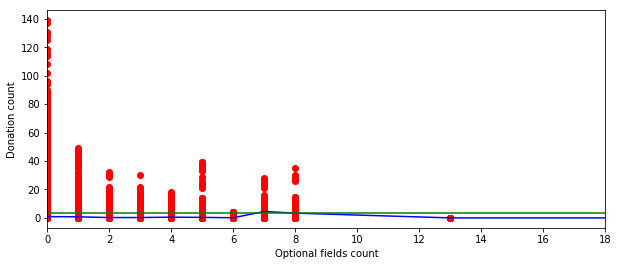

In [41]:
# scatter for all data
df_sample = df[ftrs+['don_count']]
# group by class count to see mean don_count
grpd = df[['don_count','opt_fields']].groupby('opt_fields').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs+['don_count']].sample(1)
print("Original donation count for sample: {}".format(pred_sample['don_count'].iloc[0]))
for n in range(100):
    pred_sample['opt_fields'] = n
    y_preds.append(rfr.predict(pred_sample.drop('don_count', axis=1))[0])

plt.scatter(df_sample['opt_fields'], df_sample['don_count'], color='r')
plt.plot(grpd.index, grpd['don_count'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,18)
plt.xlabel("Optional fields count")
plt.ylabel("Donation count")
plt.show()

# Bucketing

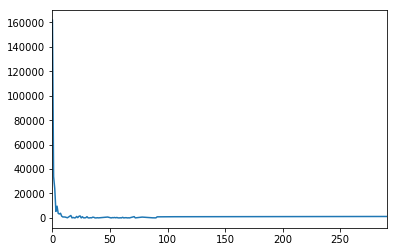

In [63]:
df.class_count.value_counts().sort_index().plot()

In [79]:
s = df.class_count.value_counts().sort_index()
df[df.class_count.isin(s[s>100].index)][['class_count', 'don_count', 'donation_conversion']].corr()

,class_count,don_count,donation_conversion
class_count,1.000000,0.097608,-0.005795
don_count,0.097608,1.000000,0.185567
donation_conversion,-0.005795,0.185567,1.000000


In [89]:
df.groupby(pd.cut(df["class_count"], bins=12))['donation_conversion'].mean()

class_count
(-0.291, 24.25]    0.011067
(24.25, 48.5]      0.017430
(48.5, 72.75]      0.025005
(72.75, 97.0]      0.007589
(97.0, 121.25]     0.000000
(121.25, 145.5]         NaN
(145.5, 169.75]         NaN
(169.75, 194.0]         NaN
(194.0, 218.25]         NaN
(218.25, 242.5]         NaN
(242.5, 266.75]         NaN
(266.75, 291.0]    0.000000
Name: donation_conversion, dtype: float64

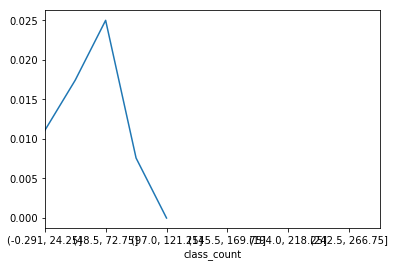

In [93]:
df.groupby(pd.cut(df["class_count"], bins=12))['donation_conversion'].mean().plot()

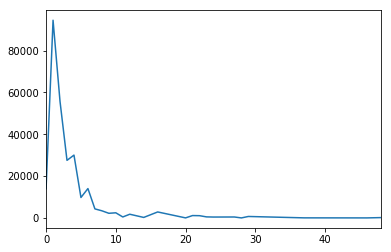

In [64]:
df.cat_count.value_counts().sort_index().plot()

In [91]:
s = df.cat_count.value_counts().sort_index()
df[df.cat_count.isin(s[s>50].index)][['cat_count', 'don_count', 'donation_conversion']].corr()

,cat_count,don_count,donation_conversion
cat_count,1.000000,-0.028011,-0.047536
don_count,-0.028011,1.000000,0.184211
donation_conversion,-0.047536,0.184211,1.000000


In [90]:
df.groupby(pd.cut(df["cat_count"], bins=12))['donation_conversion'].mean()

cat_count
(-0.048, 4.0]    0.012451
(4.0, 8.0]       0.006184
(8.0, 12.0]      0.001601
(12.0, 16.0]     0.010934
(16.0, 20.0]     0.012486
(20.0, 24.0]     0.001233
(24.0, 28.0]     0.003404
(28.0, 32.0]     0.004632
(32.0, 36.0]          NaN
(36.0, 40.0]     0.000000
(40.0, 44.0]          NaN
(44.0, 48.0]     0.025145
Name: donation_conversion, dtype: float64

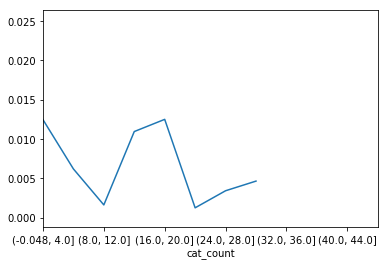

In [92]:
df.groupby(pd.cut(df["cat_count"], bins=12))['donation_conversion'].mean().plot()